# Загрузка и обработка данных

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris

In [ ]:
iris = load_iris(as_frame=True)

In [ ]:
df = iris.data

In [ ]:
df = df.join(iris.target)

In [ ]:
df = df.loc[df['target'].isin([1, 2])]

In [ ]:
df['target'] = df['target'].replace({1: 0, 2: 1})

In [ ]:
x = df.drop(columns='target')
y = np.array(df['target'])

In [ ]:
x[:5]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
50,7.0,3.2,4.7,1.4
51,6.4,3.2,4.5,1.5
52,6.9,3.1,4.9,1.5
53,5.5,2.3,4.0,1.3
54,6.5,2.8,4.6,1.5


In [ ]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Добавлю параметр заполненый 1 для того, чтобы избавиться от свободного коэфицента в дальнейшем.

In [ ]:
x = np.c_[np.ones(x.shape[0]), x]

In [ ]:
x[:5]

array([[1. , 7. , 3.2, 4.7, 1.4],
       [1. , 6.4, 3.2, 4.5, 1.5],
       [1. , 6.9, 3.1, 4.9, 1.5],
       [1. , 5.5, 2.3, 4. , 1.3],
       [1. , 6.5, 2.8, 4.6, 1.5]])

## Разделение на тренировочные и тестовые данные

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,train_size=0.8,random_state=1)

# Построение модели

## Вектор весов
 Первый вектор генерирую из 1.

In [ ]:
w = np.ones(x_train.shape[1])
w

array([1., 1., 1., 1., 1.])

## Сигмоида
Функция: σ(z) = 1 / (1 + exp(-z)), где z — линейная комбинация значений признаков и весов.

In [ ]:
def sigm(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
z = np.dot(x_train, w) # линейная комбинация значений признаков и весов

In [ ]:
y_pred = sigm(z) # предсказание

## Log loss
Функция потерь: L = - (1/m) * Σ (y * log(y_pred) + (1 - y) * log(1 - y_pred)), где y — истинное значение, y_pred — предсказанная вероятность, и m — количество объектов.

In [ ]:
def L(y_train, y_pred):
    #добавляю небольшое значение epsilon к y_pred, чтобы избежать log(0), так же вычитаю из 1.
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    #подсчет суммы
    sum_ = 0
    for i in range(len(y_train)):
        sum_ += y_train[i] * np.log(y_pred[i]) + (1-y_train[i]) * np.log(1-y_pred[i])

    return -(sum_  / len(y_pred))

In [ ]:
L(y_train, y_pred) #ошибка на весах с 1

8.085000264052015

Градиент функции потерь по каждому весу для обновления параметров.\
dw = (1/m) * Σ (y_pred - y) * X \


In [ ]:
dw = (y_pred - y_train) @ x_train / len(y_train)
dw

array([0.52499974, 3.13624857, 1.47124933, 2.24749902, 0.70499969])

# Обучение и получение результатов модели


## Получение оптимальных весов с использованием градиентного спуска

In [ ]:
lr = 0.1
epoch = 5000

In [ ]:
def log_model(x_train,y_train,lr,epoch,print_res=False):
    '''
    x_train, y_train - тренировочные данные
    Построение модели логистической регресси с использованием функции потерь log loss.
    На выходе получаем вектор весов (w).
    На вход подается x_train,y_train,lr,epoch.
    lr-длинна шага обучения,
    epoch-количество итераций,
    print_res-если True выводит промежуточный результат ошибки каждые 100 итераций
    по умолчанию False.
    '''
    w = np.zeros(x_train.shape[1])
    for i in range(epoch):
        z = x_train @ w
        y_pred = sigm(z)
        dw = (y_pred - y_train) @ x_train / len(y_train)
        w -= lr * dw

    #оценка качества моделей на каждой 100 итерации.Если print_res=True
        if print_res == True:
            if i % 100 == 0:
                print(f"Epoch {i}, Loss: {L(y_train, y_pred)}")

    return w


In [ ]:
log_model(x_train,y_train,lr,epoch)

array([-3.32457934, -3.9429564 , -4.1630525 ,  5.88082324,  6.6890781 ])

## Предсказание целевых классов.

In [ ]:
def predict_classes(x, w):
    '''
    Возвращает массив предсказаний в виде класса.
    При получении результата >= 0.5 относит элемент к 1 классу,
    иначе к 0.
    '''
    # Линейная комбинация весов и признаков
    z = x @ w
    # Преобразую вероятности с помощью сигмоиды
    probabilities = sigm(z)
    # Преобразую вероятности в классы по порогу
    return (probabilities >= 0.5) * 1

### Результаты

In [ ]:
y_pred_classes = predict_classes(x_test, log_model(x_train,y_train,lr,epoch))
y_pred_classes

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0])

In [ ]:
y_test

array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0])

## Оценка качества модели

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_pred_classes)

0.95

#Метод скользящего среднего (Root Mean Square Propagation, RMSProp).

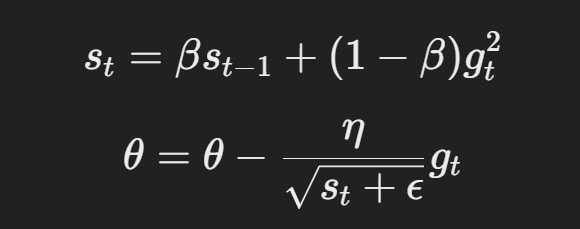

In [ ]:
def log_model_RMSProp(x_train, y_train, lr, epoch, beta=0.9, stop_loss = None, print_res=False):
    """
    Реализация RMSprop для обучения модели.
    x_train, y_train - тренировочные данные
    lr-Скорость обучения.
    beta-Коэффициент скользящего среднего (По умолчанию 0.9).
    epoch-количество итераций,
    stop_loss - ошибка для остановки, по умолчанию None
    print_res-если True выводит промежуточный результат ошибки каждые 100 итераций
    по умолчанию False.
    """

    w = np.zeros(x_train.shape[1])
    s = np.zeros(x_train.shape[1])

    def sigm(z):#сигмоида
        return 1 / (1 + np.exp(-z))

    def L(y_train, y_pred): #функция ошибки
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        sum_ = 0
        for i in range(len(y_train)):
            sum_ += y_train[i] * np.log(y_pred[i]) + (1-y_train[i]) * np.log(1-y_pred[i])
        return -(sum_  / len(y_pred))

    for i in range(epoch): #основной цикл
        z = x_train @ w
        y_pred = sigm(z)
        dw = (y_pred - y_train) @ x_train / len(y_train)
        s = beta * s + (1 - beta) * dw**2
        w -= lr * dw / (np.sqrt(s) + 1e-8)
        current_loss = L(y_train, y_pred)

        if print_res and i % 100 == 0: #оценка качества моделей на каждой 100 итерации.Если print_res=True
            print(f"Epoch {i}, Loss: {current_loss}")

        if stop_loss is not None and current_loss <= stop_loss:#остановка при допустимой ошибке
            print(f"Converged at epoch {i}, Loss: {current_loss}")
            return w

    return w

### Результаты

In [ ]:
y_pred_classes = predict_classes(x_test, log_model_RMSProp(x_train, y_train, lr, epoch))
y_pred_classes

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0])

In [ ]:
y_test

array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0])

In [ ]:
accuracy_score(y_test, y_pred_classes)

0.95

# Nesterov–accelerated Adaptive Moment Estimation, Nadam

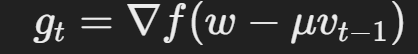

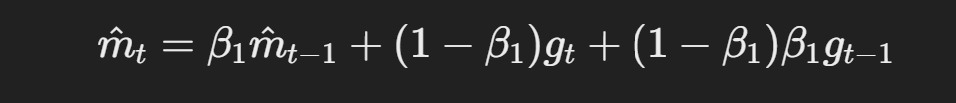

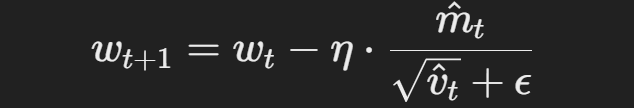

In [ ]:
def log_model_nadam(x_train, y_train, lr=0.001,epoch=1000, beta1=0.9, beta2=0.999,print_res=False):
    """
    Реализация Nadam для обучения модели.
    x_train, y_train - тренировочные данные
    lr-Скорость обучения.
    beta-Коэффициент скользящего среднего (По умолчанию 0.9).
    epoch-количество итераций,
    stop_loss - ошибка для остановки, по умолчанию None
    print_res-если True выводит промежуточный результат ошибки каждые 100 итераций
    по умолчанию False.
    """

    w = np.zeros(x_train.shape[1])  # Инициализация весов
    m, v = np.zeros_like(w), np.zeros_like(w) #Моменты

    def L(y_train, y_pred): #Функция ошибки
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        sum_ = 0
        for i in range(len(y_train)):
            sum_ += y_train[i] * np.log(y_pred[i]) + (1-y_train[i]) * np.log(1-y_pred[i])
        return -(sum_  / len(y_pred))

    for i in range(1, epoch + 1):
        z = x_train @ w
        y_pred = 1 / (1 + np.exp(-z))  # Сигмоида
        grad = (y_pred - y_train) @ x_train / len(y_train)  # Градиент

        # Обновление моментов
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad**2)

        # Смещения моментов
        m_hat = m / (1 - beta1**i)
        v_hat = v / (1 - beta2**i)

        m_hat_nesterov = beta1 * m_hat + (1 - beta1) * grad

        # Обновление весов
        w -= lr * m_hat_nesterov / (np.sqrt(v_hat) + 1e-8)

        current_loss = L(y_train, y_pred)
        if print_res and i % 100 == 0: #оценка качества моделей на каждой 100 итерации.Если print_res=True
            print(f"Epoch {i}, Loss: {current_loss}")

    return w

### Результаты

In [ ]:
log_model_nadam(x_train, y_train, lr=0.001, beta1=0.9,epoch=5000, beta2=0.999, print_res=True)

Epoch 100, Loss: 0.6572737336501615
Epoch 200, Loss: 0.6236813580981495
Epoch 300, Loss: 0.5926013850236884
Epoch 400, Loss: 0.5638523031998053
Epoch 500, Loss: 0.5372534096165185
Epoch 600, Loss: 0.5126294657337841
Epoch 700, Loss: 0.4898138480134732
Epoch 800, Loss: 0.46865048028709577
Epoch 900, Loss: 0.4489948063233576
Epoch 1000, Loss: 0.4307140580767655
Epoch 1100, Loss: 0.41368704094174935
Epoch 1200, Loss: 0.3978036108732018
Epoch 1300, Loss: 0.3829639728198004
Epoch 1400, Loss: 0.3690778915765642
Epoch 1500, Loss: 0.35606387639719317
Epoch 1600, Loss: 0.3438483788217851
Epoch 1700, Loss: 0.33236502769777443
Epoch 1800, Loss: 0.32155391475619227
Epoch 1900, Loss: 0.31136116752179943
Epoch 2000, Loss: 0.3017384055880886
Epoch 2100, Loss: 0.29264045998091237
Epoch 2200, Loss: 0.28402730627245587
Epoch 2300, Loss: 0.27586265660399345
Epoch 2400, Loss: 0.2681135695486564
Epoch 2500, Loss: 0.2607506360131621
Epoch 2600, Loss: 0.2537462366661991
Epoch 2700, Loss: 0.24707523993139419


array([-3.70605033, -1.84969509, -2.49774385,  3.37009188,  3.57812439])

In [ ]:
y_pred_classes = predict_classes(x_test, log_model_nadam(x_train, y_train, lr=0.001, beta1=0.9, beta2=0.999))
y_pred_classes

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0])

In [ ]:
accuracy_score(y_test, y_pred_classes)

0.95

# Сравните значение метрик для реализованных методов оптимизации

In [ ]:
table_res = pd.DataFrame([
    {'Name': 'Not optimization', 'Accuracy_score': 0.95, 'iterations': 5000,'Log loss' : 0.0908},
    {'Name': 'RMSProp', 'Accuracy_score': 0.95, 'iterations': 5000,'Log loss': 0.0476},
    {'Name': 'Nadam', 'Accuracy_score': 0.95, 'iterations': 5000,'Log loss': 0.150}
])

In [ ]:
table_res

,Name,Accuracy_score,iterations,Log loss
0,Not optimization,0.95,5000,0.0908
1,RMSProp,0.95,5000,0.0476
2,Nadam,0.95,5000,0.1500


# Вывод

При 5000 итерациях все модели показывают высокий результат по accuracy score = 0.95 \
Самый низкий функционал ошибки на последней итерации у RMSProp 0.0476, у модели без оптимизации 0.0908,  Nadam 0.1500. \
По результатам работы могу прийти к выводу, что не всегда оптимизация может помочь уменьшить функцию ошибки, а иногда может и увеличить её. \
 Поэтому важно выбирать метод оптимизации основываясь на особенностях данных.